In [1]:
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import matplotlib as mpl
# enables correct plotting of text
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42 

import celltypist

In [2]:
# import session_info
# session_info.show()

In [3]:
import importlib.util
import sys
spec = importlib.util.spec_from_file_location("module.name", "/nfs/team205/kk18/function/python/utils.py")
utils = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = utils
spec.loader.exec_module(utils)

In [4]:
sc.settings.set_figure_params(dpi=80)

# Variables

In [5]:
adata_dir = '/lustre/scratch126/cellgen/team205/kk18/VisiumHD/objects/subsets'
sample_id = 'HEA_FOET14880396'
celltype = 'EpicardialCells'

In [6]:
figdir = '/nfs/team205/heart/fetal_ms_figures/raw_plots_kk/Aug2024'
table_dir = '/nfs/team205/heart/fetal_ms_figures/tables/Aug2024'

# Read in data

In [7]:
# read in
adata = sc.read_h5ad(f'{adata_dir}/{sample_id}_{celltype}_b2c_cells_filtered_lognorm.h5ad')
adata

AnnData object with n_obs × n_vars = 603 × 13050
    obs: 'object_id', 'bin_count', 'array_row', 'array_col', 'labels_joint_source', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'celltypist_coarse', 'conf_score_coarse', 'celltypist_coarse_fin', 'celltypist_coarse2midmod', 'conf_score_coarse2midmod', 'celltypist_mid_fin', 'celltypist_midmod2fine', 'conf_score_midmod2fine', 'leiden_0.2', 'leiden_0.4', 'leiden_0.6', 'leiden_1', 'leiden_1.2', 'leiden_1.5', 'leiden_2'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltypist_coarse2midmod_colors', 'celltypist_coar

# Remove mid-grain markers from the feature

In [8]:
# read in
midgrain_markers = pd.read_csv('/nfs/team205/kk18/notebooks/Foetal/VisiumHD/re-seq_mpp0p3/sc_midgrain_markers.csv',
                               index_col=0
                              )
# remove the markers of celltype of interest
midgrain_markers = midgrain_markers[midgrain_markers['group']!=celltype]
midgrain_markers

group   names      scores  logfoldchanges  pvals  \
0       AtrialCardiomyocytes    MYH6  589.180000        8.461190    0.0   
1       AtrialCardiomyocytes     PAM  446.767100        5.372062    0.0   
2       AtrialCardiomyocytes    NPPA  444.359400        7.048445    0.0   
3       AtrialCardiomyocytes    MYL7  444.032530        5.999820    0.0   
4       AtrialCardiomyocytes   TNNT2  428.842380        4.739163    0.0   
...                      ...     ...         ...             ...    ...   
102668         LymphoidCells     ADK   54.743217        1.088896    0.0   
102770         LymphoidCells  FCHSD2   51.053140        1.119463    0.0   
102785         LymphoidCells   SPIDR   50.689087        1.023158    0.0   
102788         LymphoidCells  IMMP2L   50.527325        1.016055    0.0   
102906         LymphoidCells  RAD51B   47.156956        1.018748    0.0   

        pvals_adj  group_mean  
0             0.0    3.555969  
1             0.0    4.026159  
2             0.0    4.366144  
3             0.0    4.489749  
4             0.0    3.264460  
...           ...         ...  
102668        0.0    1.117559  
102770        0.0    1.309117  
102785        0.0    1.011237  
102788        0.0    1.424370  
102906        0.0    1.072148  

[2392 rows x 7 columns]

In [9]:
# remove
mask = [x not in list(midgrain_markers['names']) for x in adata.var_names]
bdata = adata[:,mask]
bdata

View of AnnData object with n_obs × n_vars = 603 × 11843
    obs: 'object_id', 'bin_count', 'array_row', 'array_col', 'labels_joint_source', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'celltypist_coarse', 'conf_score_coarse', 'celltypist_coarse_fin', 'celltypist_coarse2midmod', 'conf_score_coarse2midmod', 'celltypist_mid_fin', 'celltypist_midmod2fine', 'conf_score_midmod2fine', 'leiden_0.2', 'leiden_0.4', 'leiden_0.6', 'leiden_1', 'leiden_1.2', 'leiden_1.5', 'leiden_2'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltypist_coarse2midmod_colors', 'celltyp

# PCA, Clustering, UMAP

number of hvgs: 3273


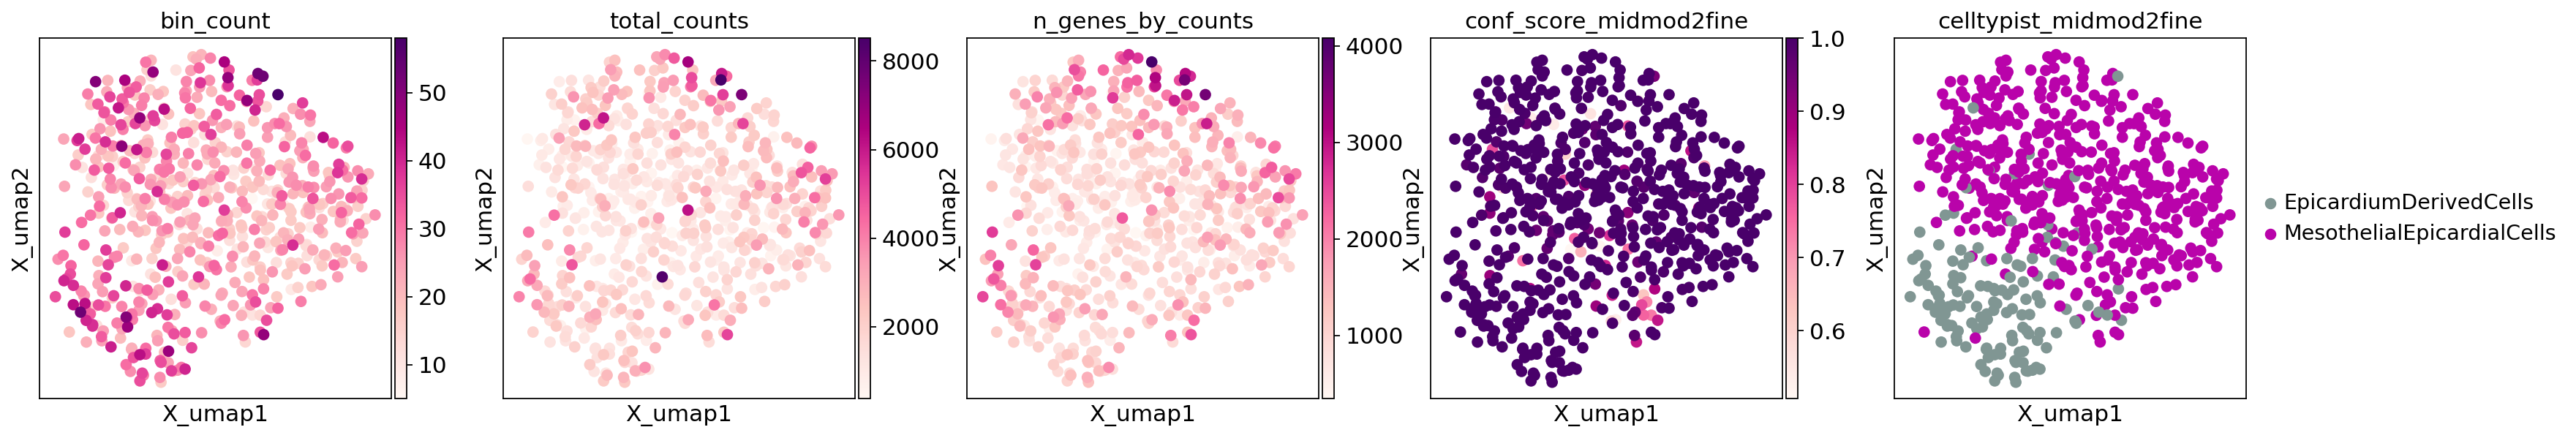

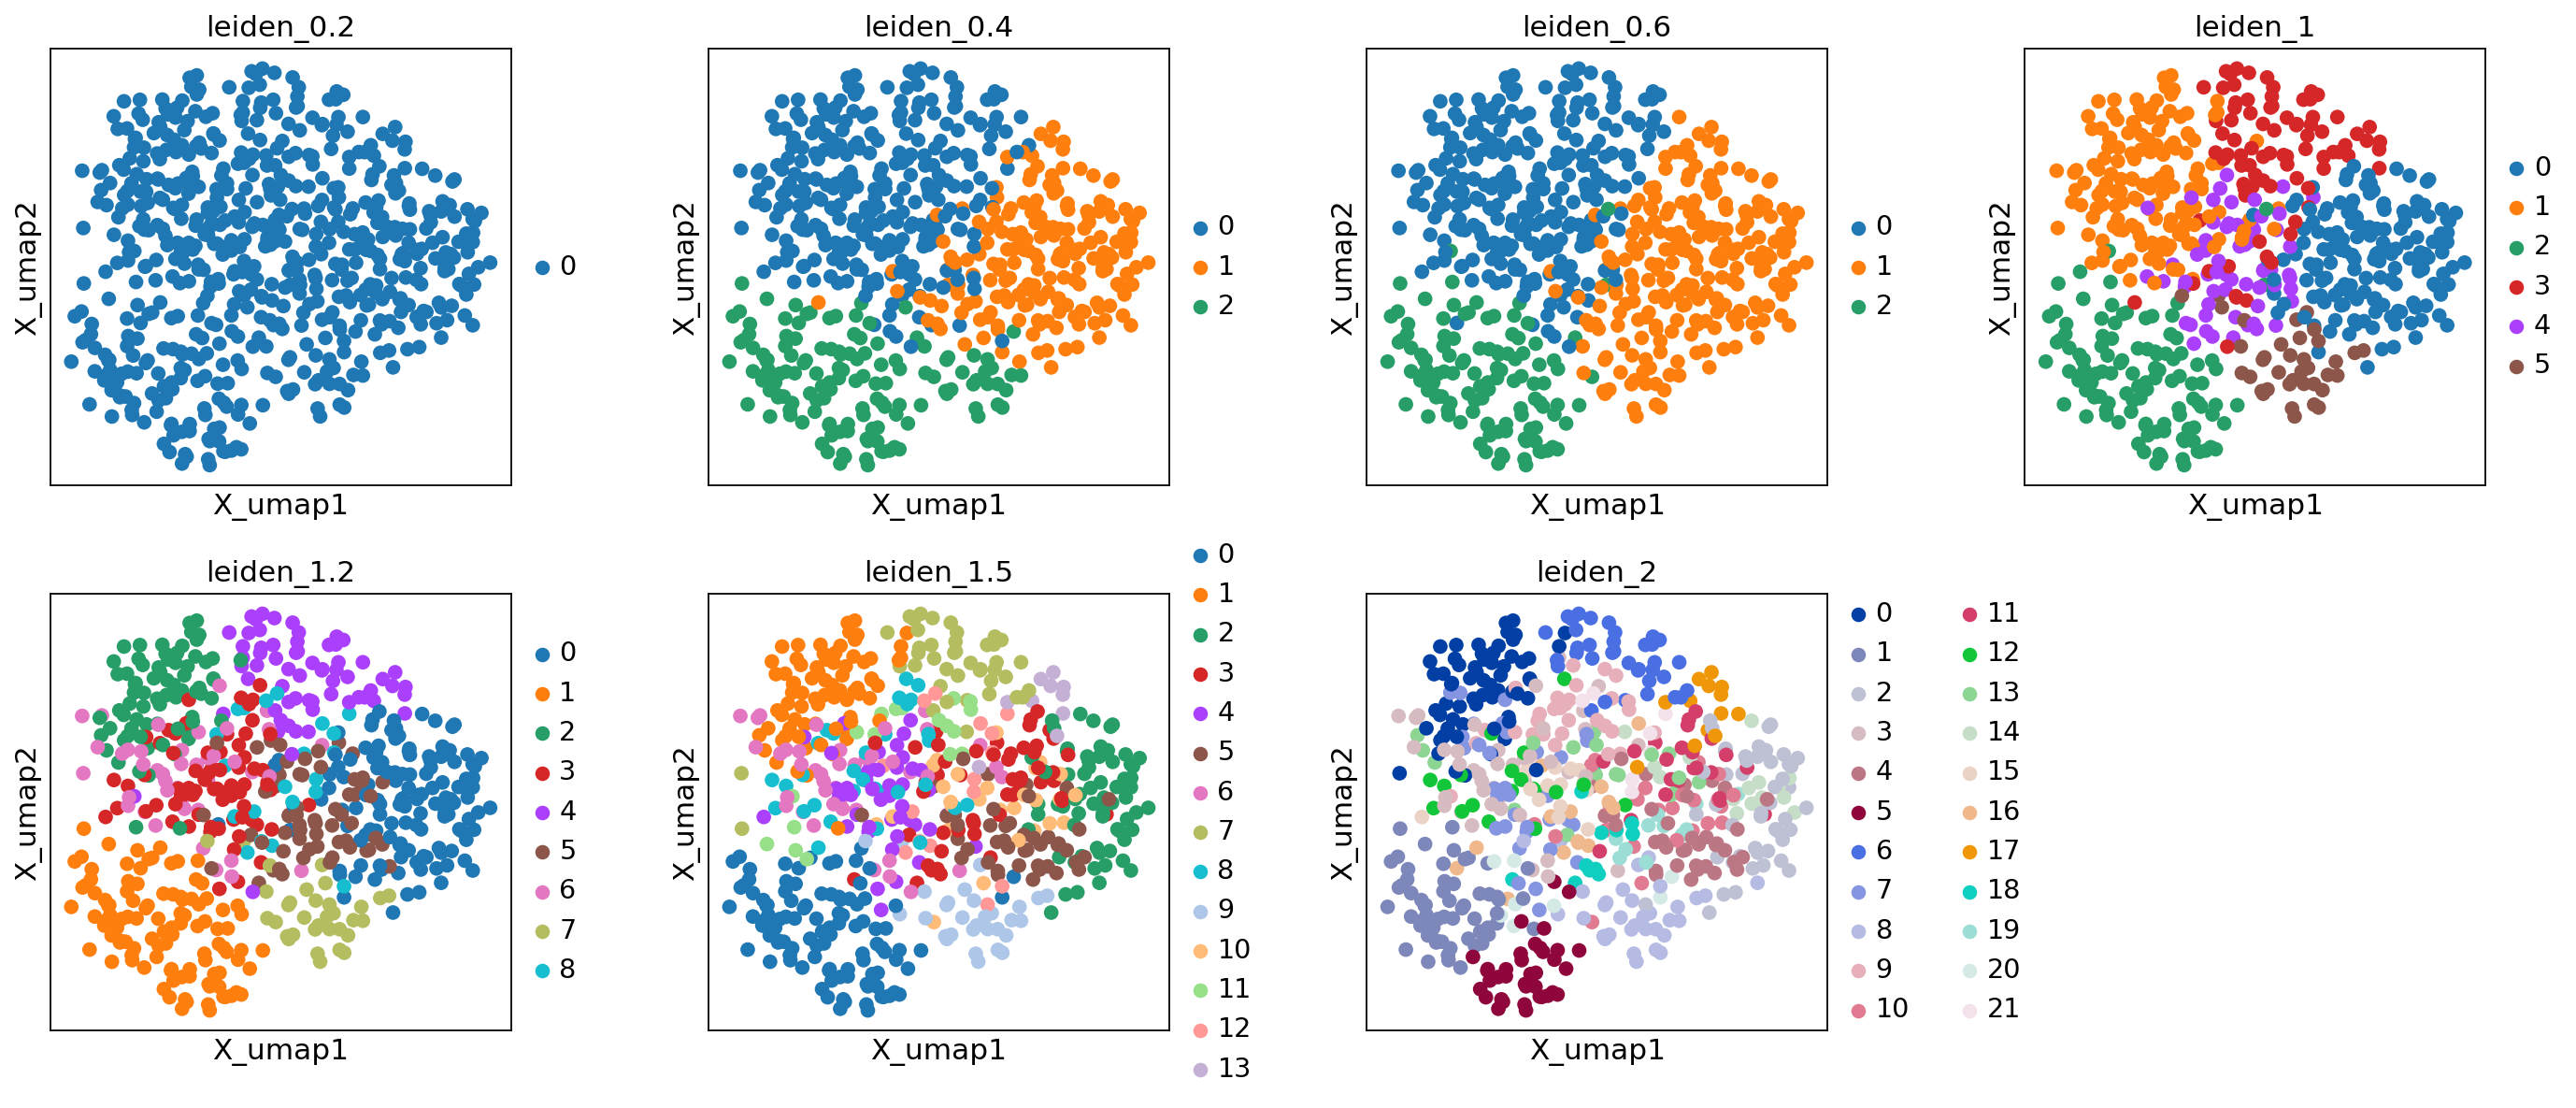

In [10]:
# HVGs, using the object which doesn't have midgrain markers
sc.pp.highly_variable_genes(bdata, flavor='seurat', min_mean=0.0125, max_mean=3, min_disp=0.5)
print(f'number of hvgs: {sum(bdata.var.highly_variable)}')
# PCA using the degected HVGs
sc.tl.pca(bdata, use_highly_variable=True)
adata.obsm['X_pca'] = bdata.obsm['X_pca'].copy()
# create neighbour graph
sc.pp.neighbors(adata,n_neighbors=15,use_rep='X_pca')
# visualisation with umap
sc.tl.umap(adata,min_dist=0.5)
sc.pl.embedding(adata,basis='X_umap',color=['bin_count','total_counts','n_genes_by_counts',"conf_score_midmod2fine","celltypist_midmod2fine",],
                wspace=0.2,cmap='RdPu',vmax='p100',ncols=5)
# leiden clustering
resolutions_list = [0.2,0.4,0.6,1,1.2,1.5,2]
for resolution in resolutions_list:
    sc.tl.leiden(adata,resolution=resolution,key_added=f'leiden_{str(resolution)}',n_iterations=2)
sc.pl.embedding(adata,basis='X_umap',
                color=[f'leiden_{str(resolution)}' for resolution in resolutions_list],
                wspace=0.3)

# Markers 

In [11]:
# read in markers identified using single-nucleus data
markers_df = pd.read_csv(f'/nfs/team205/kk18/notebooks/Foetal/VisiumHD/re-seq_mpp0p3/sc_{celltype}_finegrain_markers.csv')

mask1 = markers_df['group_mean']>1
mask2 = markers_df['logfoldchanges']>1
markers_df = markers_df[mask1&mask2]

markers_df

Unnamed: 0                       group    names     scores  \
0              0  MesothelialEpicardialCells    ITLN1  59.040577   
1              1  MesothelialEpicardialCells    TBX18  45.922650   
2              2  MesothelialEpicardialCells   SBSPON  43.830116   
3              3  MesothelialEpicardialCells   MGAT4C  38.287490   
6              6  MesothelialEpicardialCells    HMCN1  37.337100   
7              7  MesothelialEpicardialCells     TLL1  36.600540   
17            17  MesothelialEpicardialCells    PCDH9  28.240217   
20            20  MesothelialEpicardialCells  FAM155A  27.793745   
21            21  MesothelialEpicardialCells    FABP5  27.474176   
23            23  MesothelialEpicardialCells    SULF1  27.319197   
24            24  MesothelialEpicardialCells    SYNE1  26.809600   
25            25  MesothelialEpicardialCells     RYR2  26.524609   
26            26  MesothelialEpicardialCells     PRG4  25.728642   
31            31  MesothelialEpicardialCells   IGFBP5  24.405270   
35            35  MesothelialEpicardialCells  COL11A1  23.297686   
40            40  MesothelialEpicardialCells      MGP  22.641417   
43            43  MesothelialEpicardialCells   CCDC80  21.841808   
46            46  MesothelialEpicardialCells     LRP2  21.424465   
49            49  MesothelialEpicardialCells    DAAM1  20.838638   
51            51  MesothelialEpicardialCells  ALDH1A2  20.769424   
53            53  MesothelialEpicardialCells     PBX3  20.311474   
54            54  MesothelialEpicardialCells      H19  20.151949   
56            56  MesothelialEpicardialCells    SLIT3  19.975159   
57            57  MesothelialEpicardialCells    ECRG4  19.767075   
58            58  MesothelialEpicardialCells     SOX5  19.682917   
61            61  MesothelialEpicardialCells  PPFIBP1  18.824984   
64            64  MesothelialEpicardialCells    FRAS1  18.440947   
82            82  MesothelialEpicardialCells    GPM6A  16.988596   
95            95  MesothelialEpicardialCells     SOX6  16.501316   
109          109  MesothelialEpicardialCells  PLA2G2A  15.522841   
112          112  MesothelialEpicardialCells    EFNA5  15.396417   
124          124  MesothelialEpicardialCells    APBB2  14.875306   
126          126  MesothelialEpicardialCells     NAV3  14.768658   
188          189  MesothelialEpicardialCells   MARCH1  12.815235   
1765        2823      EpicardiumDerivedCells     MEG3  30.719599   
1766        2824      EpicardiumDerivedCells     GPC3  29.767492   
1767        2825      EpicardiumDerivedCells    LAMB1  29.497473   
1768        2826      EpicardiumDerivedCells      CPE  24.842453   
1769        2827      EpicardiumDerivedCells    PDE4D  21.953531   
1770        2828      EpicardiumDerivedCells      OGN  21.230026   
1771        2829      EpicardiumDerivedCells   LGALS1  21.192104   
1776        2834      EpicardiumDerivedCells      DCN  19.023909   
1782        2840      EpicardiumDerivedCells    NLGN1  16.934557   
1793        2851      EpicardiumDerivedCells   IGFBP2  15.320697   
1798        2856      EpicardiumDerivedCells    LAMA4  14.158772   
1833        2891      EpicardiumDerivedCells    NPAS3  11.822253   

      logfoldchanges          pvals      pvals_adj  group_mean  
0           3.967515   0.000000e+00   0.000000e+00    2.467452  
1           3.011310   0.000000e+00   0.000000e+00    1.399821  
2           2.916531  1.748801e-314  2.028900e-310    1.699004  
3           3.049119  1.332152e-271  1.159139e-267    1.624006  
6           2.911860  1.059595e-262  5.268459e-259    1.165930  
7           3.412810  1.209290e-254  5.261169e-251    1.135566  
17          2.605271  5.972667e-160  1.039393e-156    1.094602  
20          2.369044  7.534829e-154  1.092707e-150    1.468868  
21          1.799676  2.393602e-150  3.204205e-147    1.653379  
23          1.592274  2.439079e-144  3.031863e-141    2.242729  
24          2.050749  8.476728e-146  1.092713e-142    1.131144  
25          2.016144  7.47627

In [12]:
markers = {}
n_top = 10
for c in set(markers_df['group']):
    markers_df_sub = markers_df[markers_df['group']==c]
    markers_df_sub.sort_values('logfoldchanges',ascending=False)
    markers[c]=list(markers_df_sub[:n_top]['names'])

# manually add genes
markers['Cycling'] = ['MKI67','TOP2A'] 

genes = []
for g in markers.values():
    genes = genes + [x for x in g if (x in list(adata.var_names))&(x not in genes)]
for key in markers.keys():
    markers[key]=[x for x in markers[key] if x in list(adata.var_names)]
len(genes)

21

In [ ]:
sc.pl.embedding(adata,basis='X_umap',color=genes, # size=30,
               ncols=6, wspace=0.2,cmap='RdPu',vmax='p100')

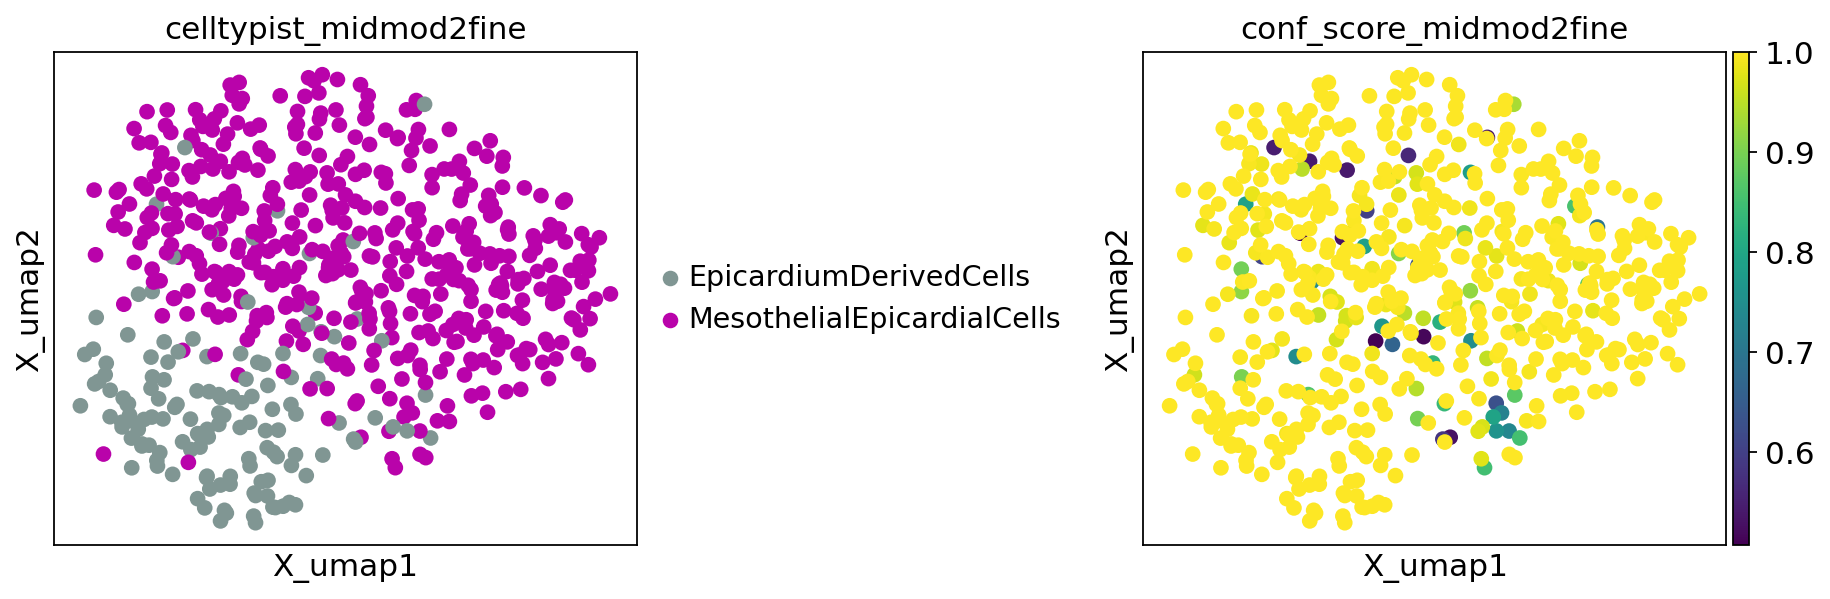

In [14]:
sc.pl.embedding(adata,basis='X_umap',
                color=['celltypist_midmod2fine', 'conf_score_midmod2fine'],
                wspace=0.7)

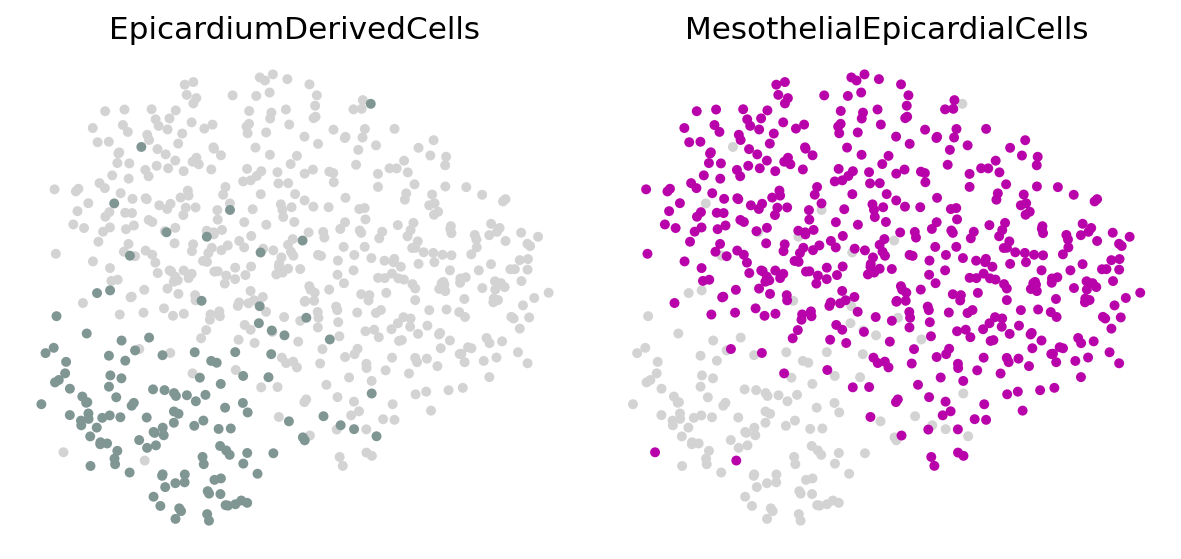

In [15]:
# umap per celltype to highlight
group_col = 'celltypist_midmod2fine'
groups_to_plot = list(set(adata.obs[group_col]))

plt.rcParams['axes.grid'] = False
fig,axs=plt.subplots(nrows=2,ncols=4,figsize=(15,7))
# Flatten the axs array for easier iteration in case of multiple rows and columns
axs_flat = axs.flatten()

for i,grp in enumerate(groups_to_plot):
    sc.pl.umap(adata, color=[group_col], groups=grp, 
               size=80, frameon=False,
               show=False, ax=axs_flat[i], legend_loc=None, legend_fontsize=5,
               title=grp
              )
# Turn off any remaining subplots
for j in range(len(groups_to_plot), len(axs_flat)):
    fig.delaxes(axs_flat[j])

# fig.suptitle('Main Title for the Figure')
fig.tight_layout()

In [16]:
resolution_sel = 1

categories: 0, 1, 2, etc.
var_group_labels: CM, FB, EC, etc.


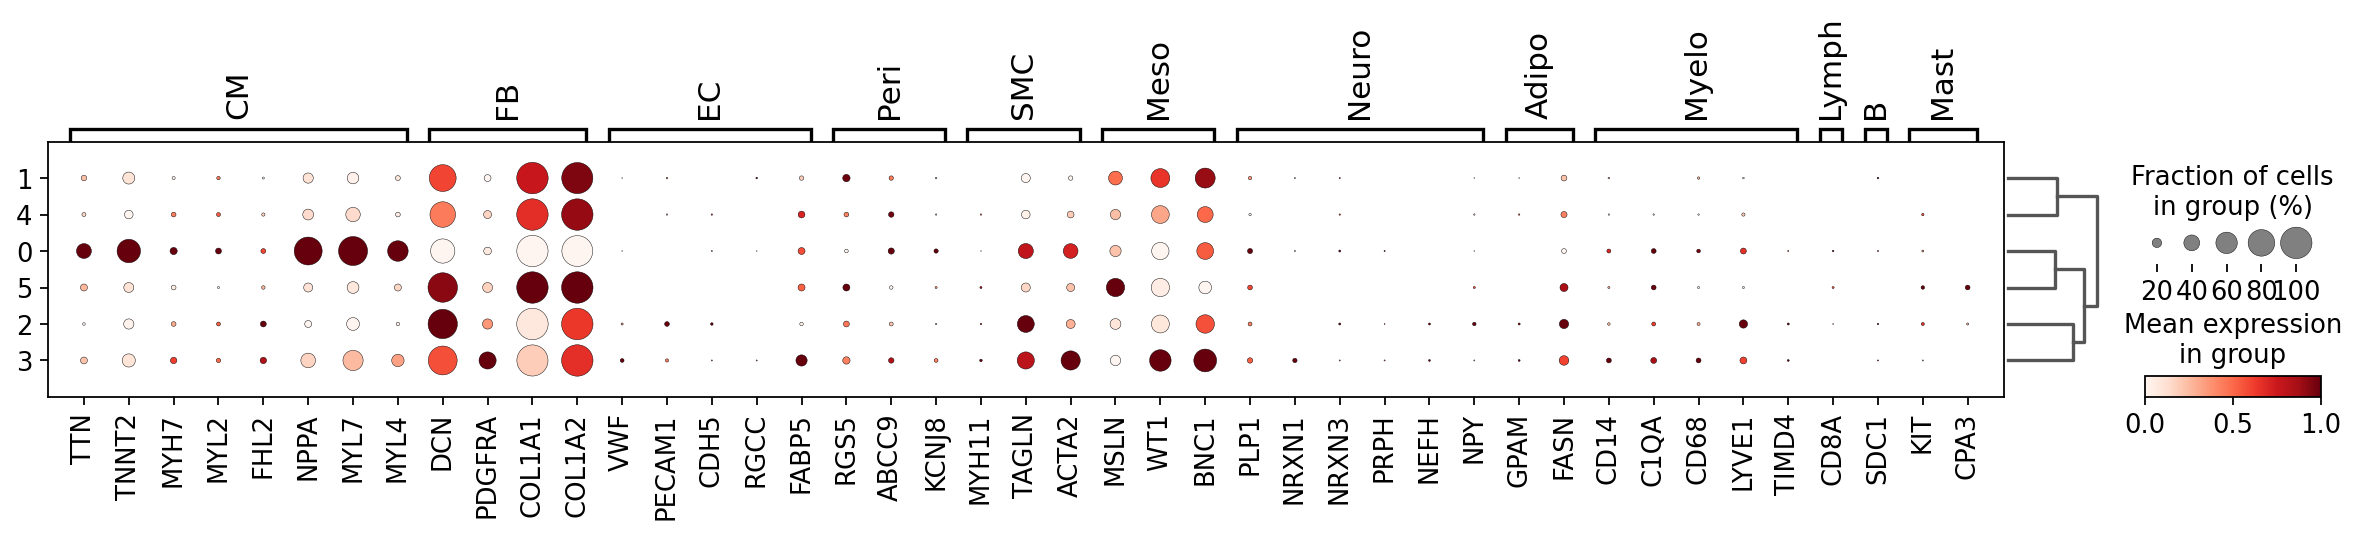

In [17]:
markers_others = {
    'CM': ['TTN', 'TNNT2','MYH6',
        'MYH7', 'MYL2', 'FHL2', # vCN
            'NPPA', 'MYL7', 'MYL4'], #aCM
    'FB': ['DCN', 'GCN', 'PDGFRA','COL1A1','COL1A2'],
    'EC': ['VWF', 'PECAM1', 'CDH5','RGCC', 'FABP5',],
    'Peri': ['RGS5', 'ABCC9', 'KCNJ8'],
    'SMC': ['MYH11', 'TAGLN', 'ACTA2'],
    'Meso': ['MSLN', 'WT1', 'BNC1'],
    'Neuro': ['PLP1', 'NRXN1', 'NRXN3','PRPH', 'NEFL', 'NEFM', 'NEFH', 'STMN2', 'SST', 'SLC10A4', 'SLC18A3', 'TH', 'NPY'],
    'Adipo': ['GPAM', 'FASN', 'LEP'],
    'Myelo': ['CD14', 'C1QA', 'CD68','LYVE1','TIMD4'],
    'Lymph': ['CD8A', 'IL7R', 'CD40LG'],
    'B': ['CD19','SDC1','IGHG1','IGHA1'],
    'Mast': ['KIT', 'CPA3'],
}

for key in markers_others.keys():
    markers_others[key]=[x for x in markers_others[key] if x in adata.var_names]

sc.tl.dendrogram(adata, groupby=f'leiden_{str(resolution_sel)}')
sc.pl.dotplot(adata,
              markers_others, 
              groupby=f'leiden_{str(resolution_sel)}',
              dendrogram=True,
              standard_scale="var",
              color_map="Reds",
              swap_axes=False,
             )

categories: 0, 1, 2, etc.
var_group_labels: EpicardiumDerivedCells, MesothelialEpicardialCells, Cycling


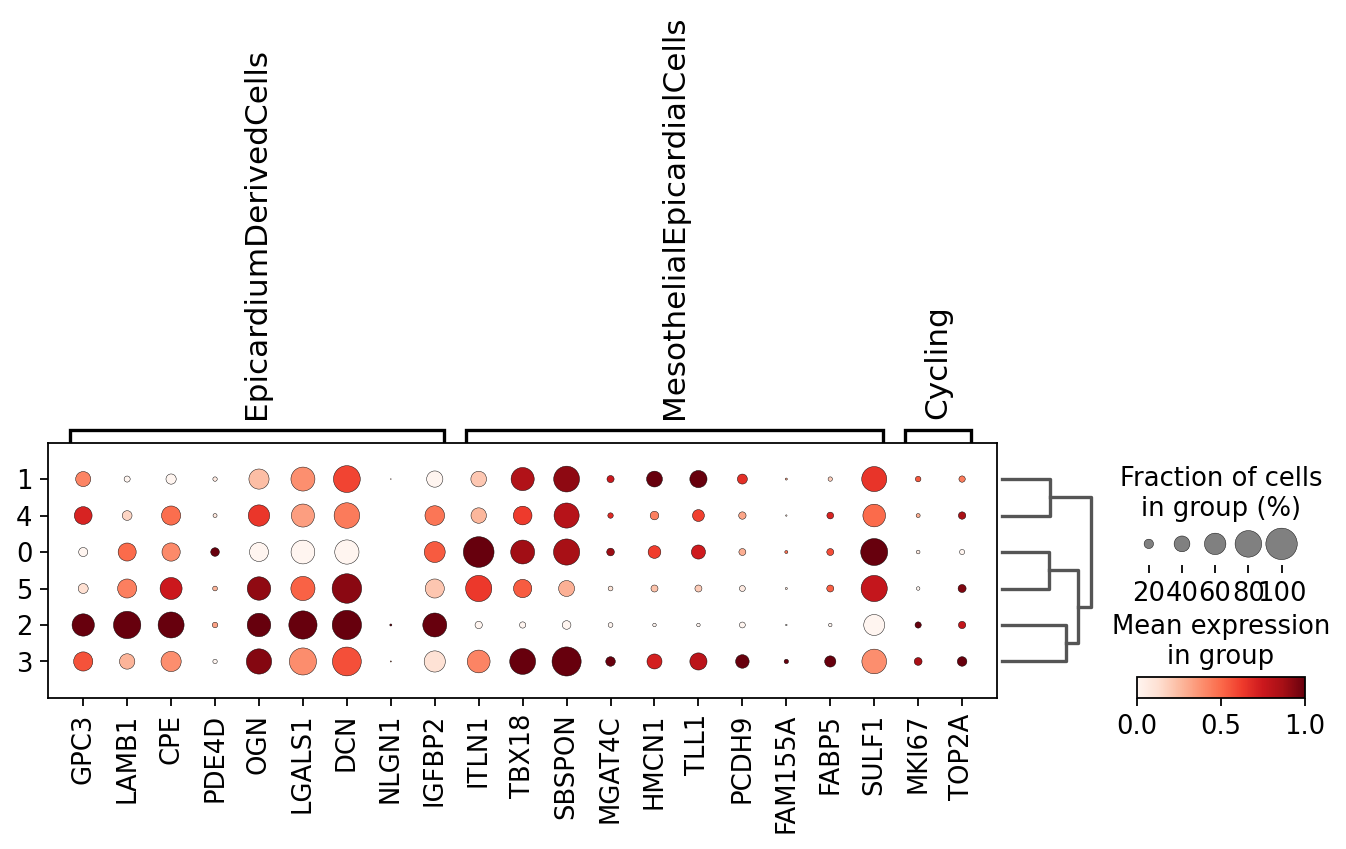

In [18]:
sc.tl.dendrogram(adata,groupby=f'leiden_{str(resolution_sel)}')
sc.pl.dotplot(adata,
              var_names=markers,
              groupby=f'leiden_{str(resolution_sel)}',
              standard_scale='var',
              dendrogram=True
             )

[2.04256052 2.77787835 1.93707821 2.4739898  3.19327673]


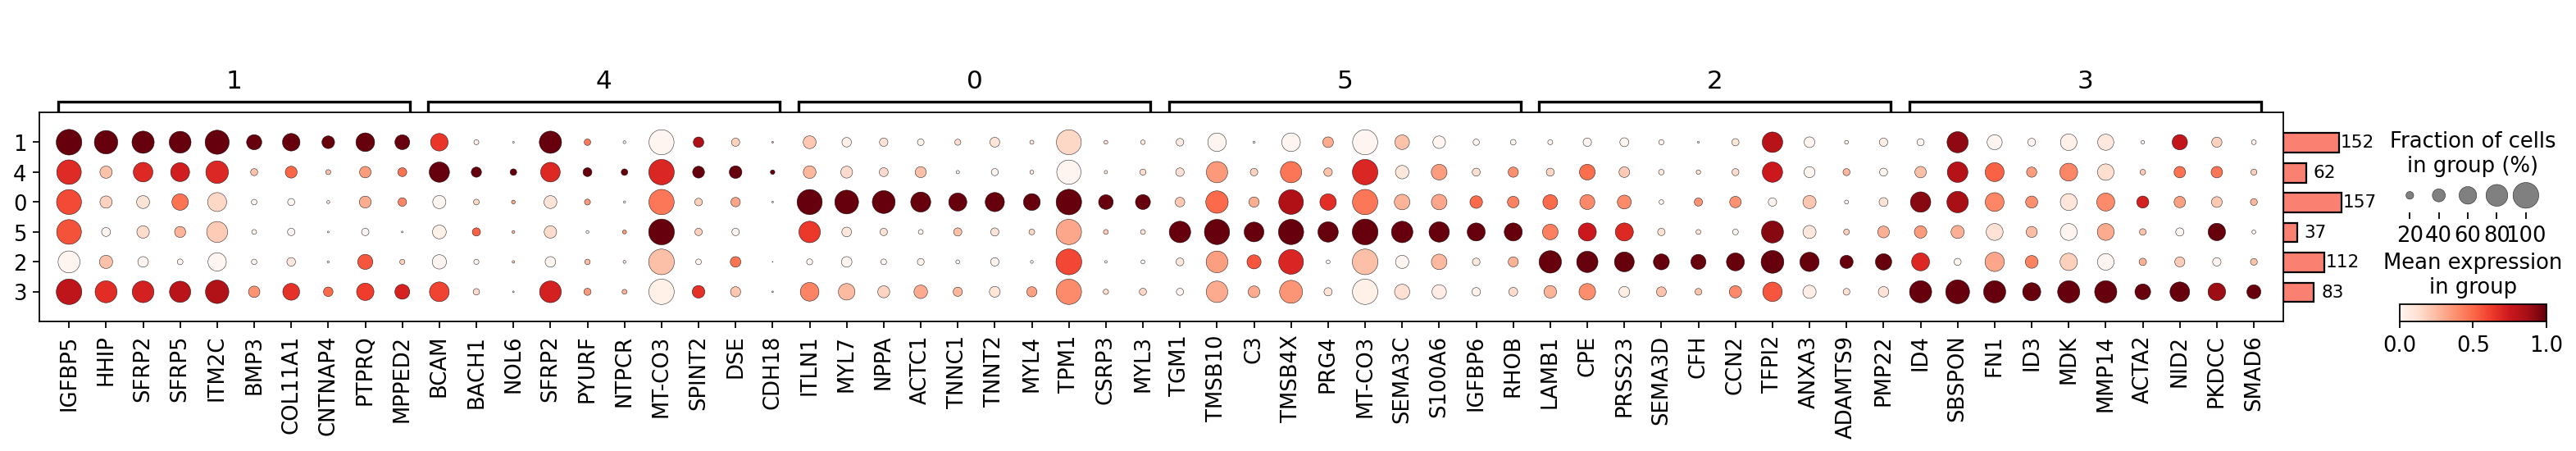

In [19]:
# DEG analysis
print(adata.X.data[:5])
adata.uns['log1p']['base']=None
sc.tl.rank_genes_groups(adata,groupby=f'leiden_{str(resolution_sel)}')
sc.tl.dendrogram(adata, groupby=f'leiden_{str(resolution_sel)}')
dp=sc.pl.rank_genes_groups_dotplot(adata, dendrogram=True, standard_scale='var', return_fig=True)
dp.add_totals().show()

[2.04256052 2.77787835 1.93707821 2.4739898  3.19327673]


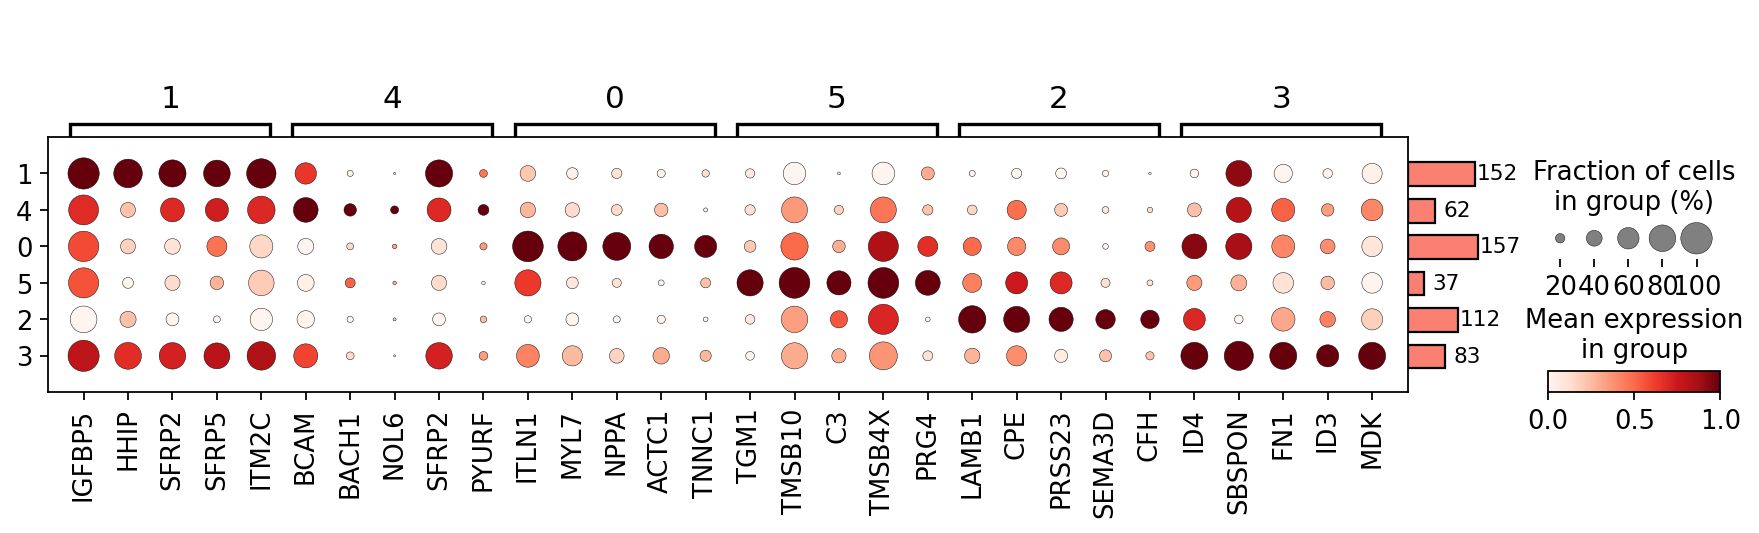

In [20]:
# DEG analysis
print(adata.X.data[:5])
adata.uns['log1p']['base']=None
sc.tl.rank_genes_groups(adata,groupby=f'leiden_{str(resolution_sel)}')
sc.tl.dendrogram(adata, groupby=f'leiden_{str(resolution_sel)}')
dp=sc.pl.rank_genes_groups_dotplot(adata, dendrogram=True, standard_scale='var', return_fig=True, n_genes=5)
dp.add_totals().show()

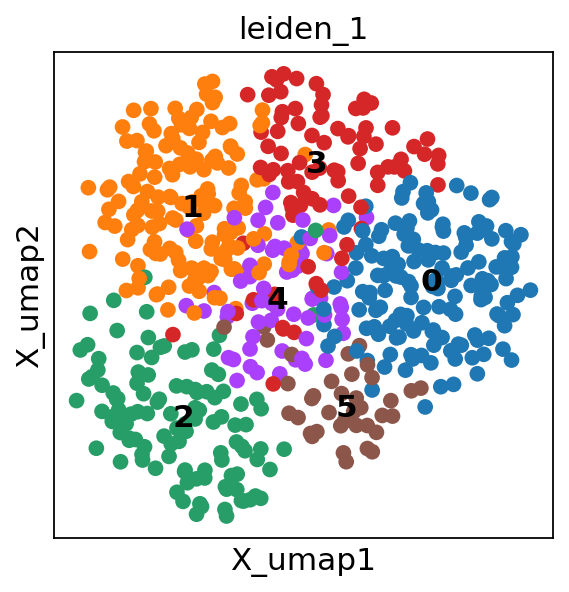

In [21]:
sc.pl.embedding(adata,basis='X_umap',
                color=f'leiden_{str(resolution_sel)}',
                wspace=0.3, legend_loc='on data')

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

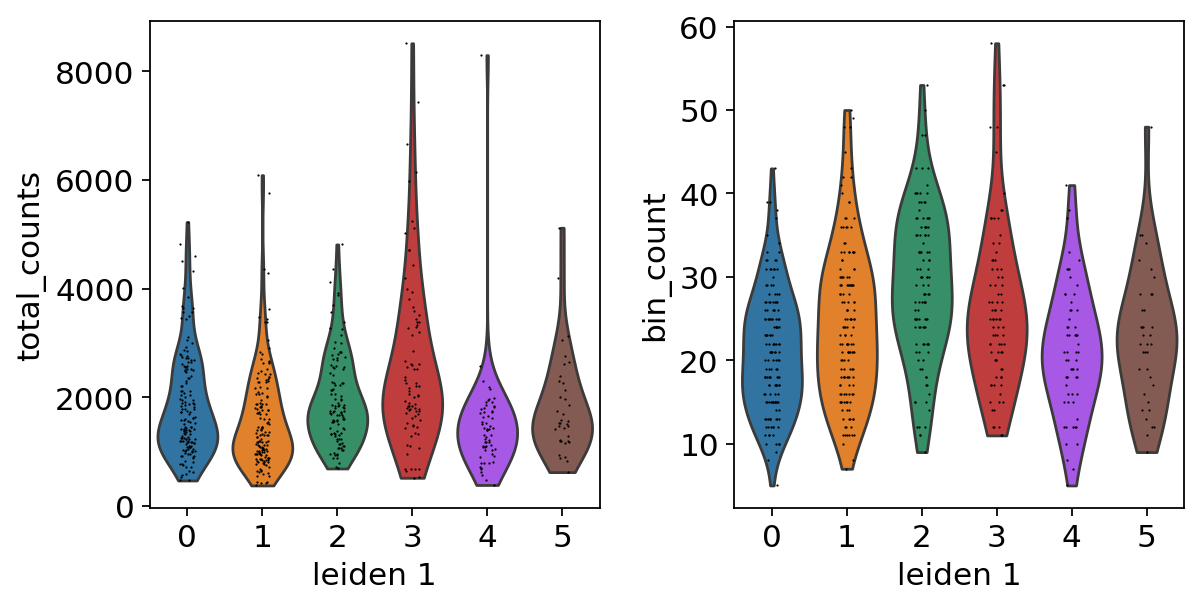

In [22]:
sc.pl.violin(adata,keys=['total_counts','bin_count'],groupby=f'leiden_{str(resolution_sel)}')

In [23]:
# annotate
adata.obs['fine_grain_manual'] = adata.obs[f'leiden_{str(resolution_sel)}'].copy()
adata.obs.replace({'fine_grain_manual':{
    '0':'MesothelialEpicardialCells', # contamination from CMs
    '1':'MesothelialEpicardialCells',
    '2':'EpicardiumDerivedCells',
    '3':'MesothelialEpicardialCells',
    '4':'MesothelialEpicardialCells', 
    '5':'MesothelialEpicardialCells',
}},inplace=True)
adata.obs['fine_grain_manual'].value_counts()

fine_grain_manual
MesothelialEpicardialCells    491
EpicardiumDerivedCells        112
Name: count, dtype: int64

In [24]:
ad = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/Feb28ObjectRaw_finegrain_updated.h5ad',backed='r')
ad = ad[ad.obs['mid_grain']==celltype]
set(ad.obs['fine_grain'])

{'EpicardiumDerivedCells', 'MesothelialEpicardialCells'}

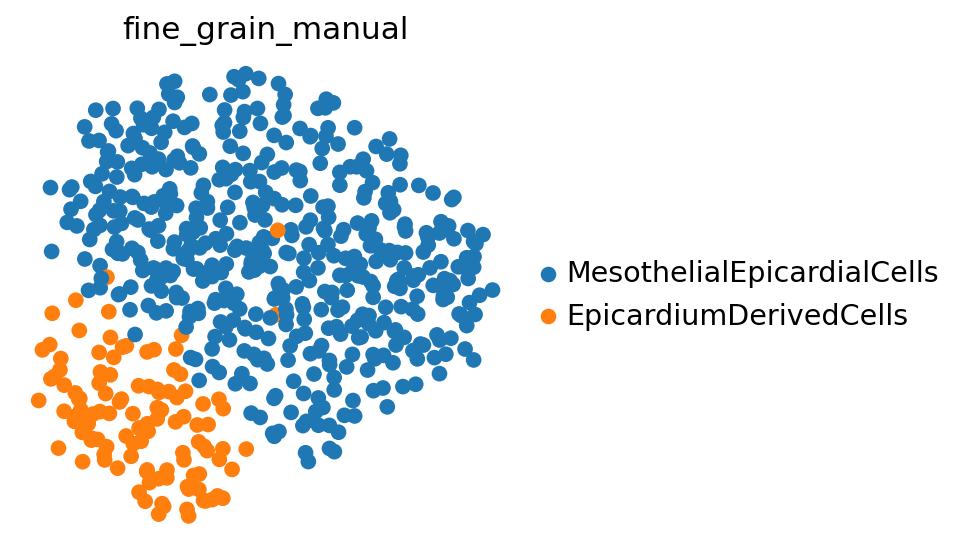

In [25]:
sc.pl.embedding(adata,basis='X_umap',
                color='fine_grain_manual',
                frameon=False,
                wspace=0.3)

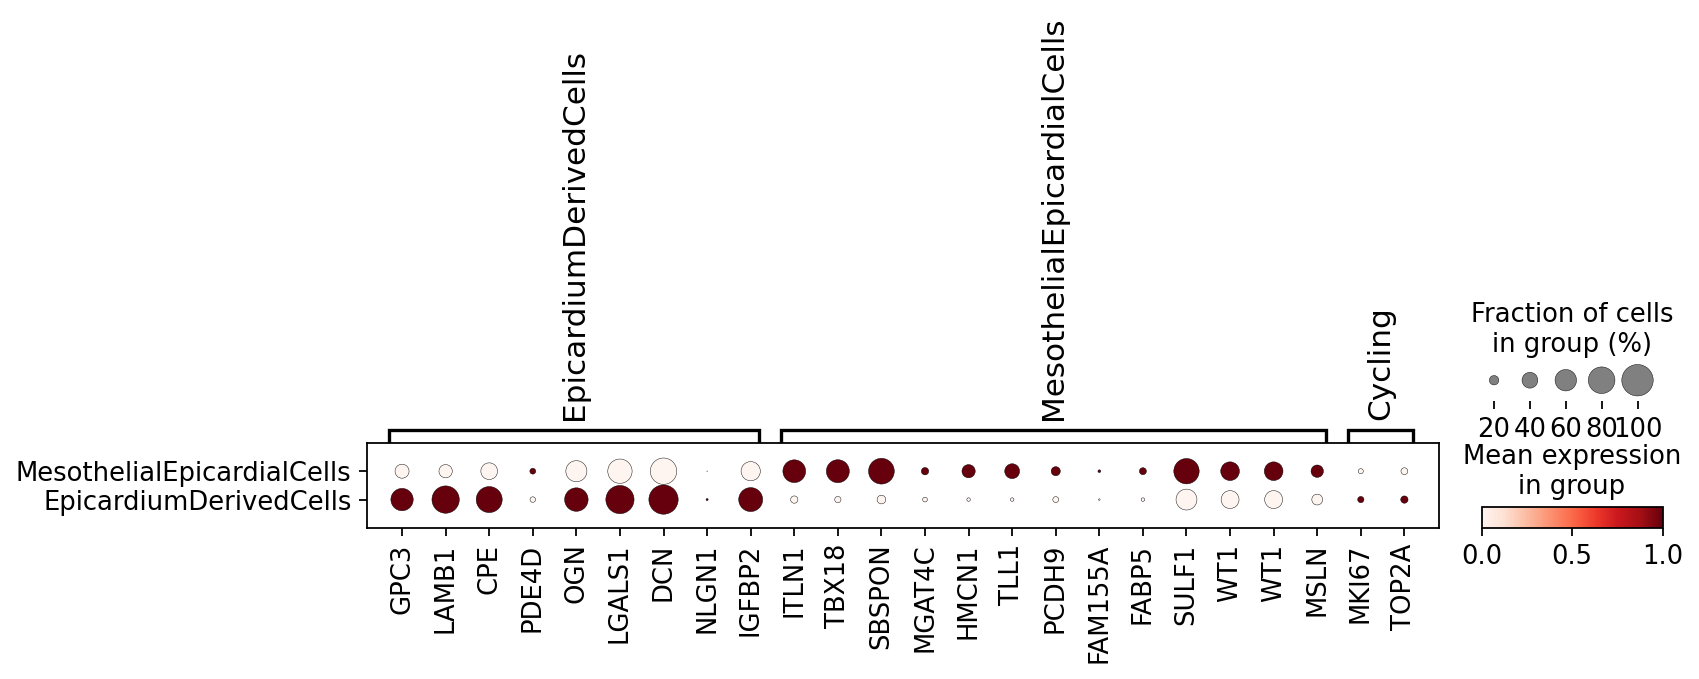

In [29]:
markers['MesothelialEpicardialCells']=markers['MesothelialEpicardialCells']+['WT1','MSLN']

sc.tl.dendrogram(adata,groupby=f'leiden_{str(resolution_sel)}')
sc.pl.dotplot(adata,
              var_names=markers,
              groupby='fine_grain_manual',
              standard_scale='var',
              dendrogram=True
             )

# Save

In [30]:
# save
adata.write(f'{adata_dir}/{sample_id}_{celltype}_b2c_cells_filtered_lognorm.h5ad')
print(f'{adata_dir}/{sample_id}_{celltype}_b2c_cells_filtered_lognorm.h5ad')

/lustre/scratch126/cellgen/team205/kk18/VisiumHD/objects/subsets/HEA_FOET14880396_EpicardialCells_b2c_cells_filtered_lognorm.h5ad
